# Finetuning SubuGPT
### 1. Importing Instruction files
- Import your instruction file satisfying the following conditions:
  1. Must be `.json` file
  2. Each entry in instruction file must have instruction,input(optional) and output.
- Here we are importing the instruction file `Dataset/instruction-data.json` from the repository https://github.com/SubuMangu/SubuGPT as an example.

In [1]:
import json
import os
import urllib


def download_and_load_file(file_path, url):

    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)

    with open(file_path, "r", encoding="utf-8") as file:
        data = json.load(file)

    return data

## Importing instruction dataset
file_path = "instruction-data.json"
url = "https://raw.githubusercontent.com/SubuMangu/SubuGPT/refs/heads/main/Dataset/instruction-data.json"

data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))

Number of entries: 1100


- To import a file from github:
  1. Click on `Raw` in top right corner region

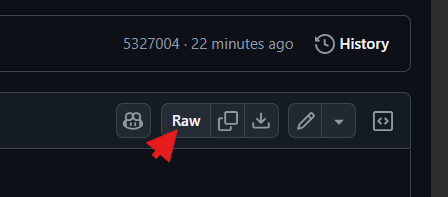

  2. Copy url

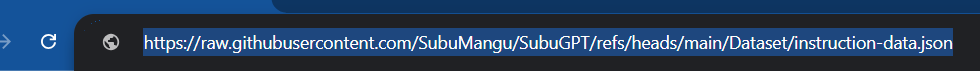

3. Use the url to retrieve the file using `urllib.request.urlretrieve(url, file_path)` as shown below.
- We are importing neccessary files like `GPTModules.py` and `gpt_download.py`

In [2]:
# Importing neccesary GPT Modules
if not os.path.exists("GPTModules.py"):
    url = ("https://raw.githubusercontent.com/SubuMangu/SubuGPT/refs/heads/main/GPTModules.py")
    file_path = "GPTModules.py"
    urllib.request.urlretrieve(url, file_path)
# Importing files to  download gpt models from openai
if not os.path.exists("gpt_download.py"):
    url = ("https://raw.githubusercontent.com/SubuMangu/SubuGPT/refs/heads/main/gpt_download.py")
    file_path = "gpt_download.py"
    urllib.request.urlretrieve(url, file_path)


### 2. Formating entries

In [3]:
def format_input(entry):
  # Can change the name of the keys in entry in the function match the component name of each entry
  # Don't change this format of instruction
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

In [4]:
model_input = format_input(data[50])
desired_response = f"\n\n### Response:\n{data[50]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion

### Response:
The correct spelling is 'Occasion.'


### 3. Creating Instruction Dataset

In [5]:
!pip install tiktoken
import torch
import tiktoken
from GPTModules import InstructionDataset,custom_collate_fn
from GPTModules import generate,text_to_token_ids,token_ids_to_text

In [6]:
train_portion = int(len(data) * 0.85)  # 85% for training
test_portion = int(len(data) * 0.1)    # 10% for testing
val_portion = len(data) - train_portion - test_portion  # Remaining 5% for validation

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

In [7]:
print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 935
Validation set length: 55
Test set length: 110


In [8]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
from functools import partial

customized_collate_fn = partial(
    custom_collate_fn,
    device=device,
    allowed_max_length=1024
)

In [10]:
from torch.utils.data import DataLoader
tokenizer = tiktoken.get_encoding("gpt2")

num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

In [11]:
val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

### 3. Loading pretrained weights to the

In [12]:
config={
    'vocab_size': 50257,
    'context_length': 1024,
    'drop_rate': 0.0,
    'qkv_bias': True,
    'dim': 1024,
    'num_layers': 24,
    'num_heads': 16
    }

In [13]:
from GPTModules import GPTModel
from huggingface_hub import hf_hub_download
model=GPTModel(config)
model_path = hf_hub_download(
    repo_id="subumangu2003/subugpt",
    filename="model.pth"
    )
model.load_state_dict(torch.load(model_path,map_location=torch.device('cpu'), weights_only=True))
model.eval();
model.to(device);

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_fp16.pth:   0%|          | 0.00/863M [00:00<?, ?B/s]

In [14]:
torch.manual_seed(123)

input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'


### 4. Finetune the model

In [15]:
from GPTModules import train_model

In [16]:
import time

start_time = time.time()
num_epochs = 5
train_losses,val_losses,epochs=train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=num_epochs,
    start_text=format_input(val_data[0]),
    tokenizer=tokenizer,
    new_tokens=50,
    learning_rate=0.00005,
    device=device
)
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Epoch 1: Train loss 0.17765755951404572, Val loss 0.7429252862930298
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'

### Response:
The meal is prepared each day by the chef.
Epoch 2: Train loss 0.16812710464000702, Val loss 0.7753307819366455
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'

### Response:
The chef serves the meal every day.
Epoch 3: Train loss 0.15903398394584656, Val loss 0.755196213722229
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'

### Response:
The meal is cooked daily by the chef.
Epoch 4: Train loss 0.1485481

In [17]:
import subprocess

def show_gpu_memory():
    try:
        result = subprocess.check_output(
            ['nvidia-smi', '--query-gpu=memory.used,memory.total', '--format=csv,nounits,noheader']
        )
        gpus = result.decode().strip().split('\n')
        for idx, gpu in enumerate(gpus):
            used, total = map(int, gpu.split(','))
            print(f"GPU {idx}: {used} MB / {total} MB used ({(used/total)*100:.1f}%)")
    except FileNotFoundError:
        print("nvidia-smi not found. Make sure NVIDIA drivers are installed and in your PATH.")
    except Exception as e:
        print(f"Error while checking GPU memory: {e}")

# Call the function
show_gpu_memory()

GPU 0: 8320 MB / 15360 MB used (54.2%)


### 5. Download the instruction with reponse data

In [19]:
from tqdm import tqdm

for i, entry in tqdm(enumerate(test_data), total=len(test_data)):

    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=config["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = generated_text[len(input_text):].replace("### Response:", "").strip()

    test_data[i]["model_response"] = response_text


with open("instruction-data-with-response.json", "w") as file:
    json.dump(test_data, file, indent=4)  # "indent" for pretty-printing

100%|██████████| 110/110 [00:57<00:00,  1.91it/s]


### 6. Save and Download the model

In [20]:
torch.save(model.state_dict(), "model.pth")

In [21]:
from huggingface_hub import notebook_login

notebook_login()  # will ask you for your HF token

In [23]:
from huggingface_hub import upload_file

upload_file(
    path_or_fileobj="model.pth",  # your updated file
    path_in_repo="model.pth",     # name in repo
    repo_id="subumangu2003/subugpt",   # your repo
    repo_type="model"                  # it's a model repo
)

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  model_fp16.pth                        :   2%|1         | 33.5MB / 1.73GB            

CommitInfo(commit_url='https://huggingface.co/subumangu2003/subugpt/commit/519fcee3f4ae806c41351c744828151fbfbdadba', commit_message='Upload model.pth with huggingface_hub', commit_description='', oid='519fcee3f4ae806c41351c744828151fbfbdadba', pr_url=None, repo_url=RepoUrl('https://huggingface.co/subumangu2003/subugpt', endpoint='https://huggingface.co', repo_type='model', repo_id='subumangu2003/subugpt'), pr_revision=None, pr_num=None)